<a href="https://colab.research.google.com/github/ChuChuUp/20F_1008_DL/blob/master/MNIST_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import torch
from torch import nn, optim
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import pandas as pd
from collections import Counter
import numpy as np 
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.datasets import fetch_openml
from google.colab import output
import matplotlib.pyplot as plt

#### Download the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
X.shape, y.shape

((70000, 784), (70000,))

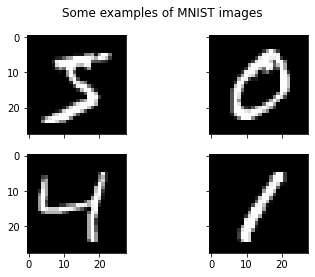

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Some examples of MNIST images')
ax1.imshow(X[0].reshape(28,28), cmap='gray')
ax2.imshow(X[1].reshape(28,28), cmap='gray')
ax3.imshow(X[2].reshape(28,28), cmap='gray')
ax4.imshow(X[3].reshape(28,28), cmap='gray')

for ax in fig.get_axes():
    ax.label_outer()

In [ ]:
y = np.array([float(ele) for ele in y])

#### Divide the training set into train and validation. Use this set to tune the hyper parameters

In [ ]:
shuf = torch.randperm(y.shape[0])

# Shuffle the data first incase they are saved in some ordering  
y = y[shuf]
X = X[shuf,:]

X_train = X[:50_000]
y_train = y[:50_000]

X_val = X[50_000:60_000]
y_val = y[50_000:60_000]

X_test = X[60_000:]
y_test = y[60_000:]

# Optionally : torch.utils.data.random_split(dataset, lengths)

In [ ]:
num_classes = len(set(y))
print(num_classes)

10


#### Calculate statistics and normalise the data 

In [ ]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train -= mean # Zero center the data
X_train /= std + 1e-4 # Make it unit variance 

X_val -= mean # Notice that you use the statistics computed on train data for this step
X_val /= std + 1e-4

X_test -= mean # Notice that you use the statistics computed on train data for this step
X_test /= std +1e-4

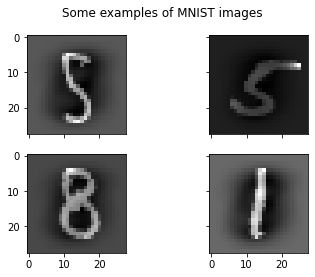

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Some examples of MNIST images')
ax1.imshow(X_val[0].reshape(28,28), cmap='gray')
ax2.imshow(X_val[1].reshape(28,28), cmap='gray')
ax3.imshow(X_val[2].reshape(28,28), cmap='gray')
ax4.imshow(X_val[3].reshape(28,28), cmap='gray')

for ax in fig.get_axes():
    ax.label_outer()

#### Make Pytorch Dataset 

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.labels = torch.as_tensor(y, dtype=torch.long).to(device)
        self.data = torch.as_tensor(X, dtype=torch.float).to(device)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = {'x' : self.data[idx], 'y': self.labels[idx] }
        return sample

In [ ]:
train_dataset = MNISTDataset(X_train, y_train)
print(f"Lenth of train dataset {len(train_dataset)}")
val_dataset = MNISTDataset(X_val, y_val)
print(f"Lenth of val dataset {len(val_dataset)}")
test_dataset = MNISTDataset(X_test, y_test)
print(f"Lenth of test dataset {len(test_dataset)}")

Lenth of train dataset 50000
Lenth of val dataset 10000
Lenth of test dataset 10000


#### Define the data sampler

In [ ]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
val_sampler = torch.utils.data.SequentialSampler(val_dataset)
test_sampler = torch.utils.data.SequentialSampler(test_dataset)

#### Define the data loader 

In [ ]:
bs = 1024 # Define the batch size

train_loader = DataLoader(train_dataset, batch_size=bs, sampler=train_sampler, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=bs, sampler=val_sampler, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=bs, sampler=test_sampler, drop_last=False)

In [ ]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
D = X_train.shape[1] # number of feature dimensions
C = num_classes  # num_classes
H = 128 

#### Linear model

In [ ]:
learning_rate = 1e-3
lambda_l2 = 1e-5

# nn package to create our linear model
# each Linear module has a weight and bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, C),
)
model.to(device) #Convert to CUDA

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
                            weight_decay=lambda_l2) # built-in L2

# Training
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for t in tqdm(range(300)):
    epoch_t_acc = 0.0 
    epoch_t_loss = 0.0
    
    for i, samples in enumerate(train_loader):
        model.train()
        # Feed forward to get the logits
        y_pred_train = model(samples['x'])

        # Compute the loss and accuracy
        loss = criterion(y_pred_train, samples['y'])
        score, predicted = torch.max(y_pred_train, 1)
        train_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()
        
        epoch_t_acc += train_acc
        epoch_t_loss += loss.item()
    
    train_accuracies.append(epoch_t_acc/len(train_loader))
    train_losses.append(epoch_t_loss/len(train_loader))
    
    model.eval()
    
    v_acc = 0.0
    v_loss = 0.0 
    
    with torch.no_grad():
        for i, samples in enumerate((val_loader)):
            y_pred_val = model(samples['x'])
            score, predicted = torch.max(y_pred_val, 1)
            val_loss = criterion(y_pred_val, samples['y'])
            val_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])
            
            v_acc += val_acc
            v_loss += val_loss.item()
            
    val_accuracies.append(v_acc/len(val_loader))
    val_losses.append(v_loss/len(val_loader))

    if t%50 == 0:
        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))


[EPOCH]: 0, [TRAIN LOSS]: 2.268290, [TRAIN ACCURACY]: 0.142
[EPOCH]: 0, [VAL LOSS]: 3.283117, [VAL ACCURACY]: 0.194 

[EPOCH]: 50, [TRAIN LOSS]: 0.633092, [TRAIN ACCURACY]: 0.846
[EPOCH]: 50, [VAL LOSS]: 3.463064, [VAL ACCURACY]: 0.845 

[EPOCH]: 100, [TRAIN LOSS]: 0.429832, [TRAIN ACCURACY]: 0.882
[EPOCH]: 100, [VAL LOSS]: 3.780258, [VAL ACCURACY]: 0.877 

[EPOCH]: 150, [TRAIN LOSS]: 0.371584, [TRAIN ACCURACY]: 0.895
[EPOCH]: 150, [VAL LOSS]: 3.883698, [VAL ACCURACY]: 0.890 

[EPOCH]: 200, [TRAIN LOSS]: 0.342452, [TRAIN ACCURACY]: 0.902
[EPOCH]: 200, [VAL LOSS]: 3.923202, [VAL ACCURACY]: 0.896 

[EPOCH]: 250, [TRAIN LOSS]: 0.323622, [TRAIN ACCURACY]: 0.907
[EPOCH]: 250, [VAL LOSS]: 3.949255, [VAL ACCURACY]: 0.900 




In [ ]:
print(model)
print(f"Training accuracy of final model : {train_accuracies[-1]}")
print(f"Validation accuracy of final model: {val_accuracies[-1]}")
print(f"Training loss of final model: {train_losses[-1]}")
print(f"Validation loss of final model: {val_losses[-1]}")

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=10, bias=True)
)
Training accuracy of final model : 0.9110651612281799
Validation accuracy of final model: 0.9069833755493164
Training loss of final model: 0.31110587047070876
Validation loss of final model: 2.5113200902938844


(0.18208475393908366, 2.8915282011032106)

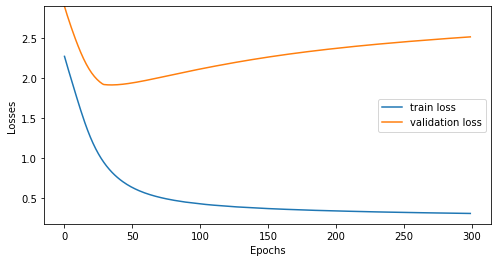

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.ylim(top=np.max(train_losses+val_losses))

#### Non linear model - Same size as above but with ReLU 

In [ ]:
learning_rate = 1e-4
lambda_l2 = 1e-4

# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H,C),
)

model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
best_val = 0.0
train_losses = []
val_losses = []
train_accuracies = []


# Training
for t in tqdm(range(200)):
    epoch_t_acc = 0.0 
    epoch_t_loss = 0.0
    
    for i, samples in enumerate(train_loader):
        model.train()
        # Feed forward to get the logits
        y_pred_train = model(samples['x'])

        # Compute the loss and accuracy
        loss = criterion(y_pred_train, samples['y'])
        score, predicted = torch.max(y_pred_train, 1)
        train_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()
        
        epoch_t_acc += train_acc
        epoch_t_loss += loss.item()
    
    train_accuracies.append(epoch_t_acc/len(train_loader))
    train_losses.append(epoch_t_loss/len(train_loader))
    
    model.eval()
    
    v_acc = 0.0
    v_loss = 0.0
    
    with torch.no_grad():
        for i, samples in enumerate(val_loader):
            y_pred_val = model(samples['x'])
            score, predicted = torch.max(y_pred_val, 1)
            val_loss = criterion(y_pred_val, samples['y'])
            val_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])
            
            v_acc += val_acc
            v_loss += val_loss.item()
            
    val_accuracies.append(v_acc/len(val_loader))
    val_losses.append(v_loss/len(val_loader))
    
    if t%50 == 0:
        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))
        


[EPOCH]: 0, [TRAIN LOSS]: 2.125658, [TRAIN ACCURACY]: 0.481
[EPOCH]: 0, [VAL LOSS]: 1.945039, [VAL ACCURACY]: 0.664 

[EPOCH]: 50, [TRAIN LOSS]: 0.048917, [TRAIN ACCURACY]: 0.987
[EPOCH]: 50, [VAL LOSS]: 0.101506, [VAL ACCURACY]: 0.971 

[EPOCH]: 100, [TRAIN LOSS]: 0.010343, [TRAIN ACCURACY]: 0.999
[EPOCH]: 100, [VAL LOSS]: 0.097017, [VAL ACCURACY]: 0.973 

[EPOCH]: 150, [TRAIN LOSS]: 0.002721, [TRAIN ACCURACY]: 1.000
[EPOCH]: 150, [VAL LOSS]: 0.105663, [VAL ACCURACY]: 0.972 




In [ ]:
print(model)
print(f"Training accuracy of final model : {train_accuracies[-1]}")
print(f"Validation accuracy of final model: {val_accuracies[-1]}")
print(f"Training loss of final model: {train_losses[-1]}")
print(f"Validation loss of final model: {val_losses[-1]}")

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
)
Training accuracy of final model : 1.0
Validation accuracy of final model: 0.9732462167739868
Training loss of final model: 0.0014489311107187246
Validation loss of final model: 0.10517117232084275


(-0.10476150293193034, 2.1256576119637)

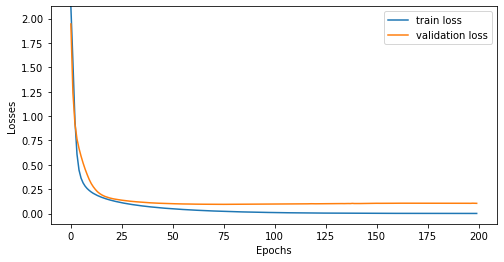

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.ylim(top=np.max(train_losses+val_losses))

#### We see that the model is overfitting : Notice the gap between the train and validation losses. 

#### Use dropout to reduce overfitting 

In [ ]:
learning_rate = 1e-4
lambda_l2 = 1e-4

# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(H,C),
)

model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
best_val = 0.0
train_losses = []
val_losses = []
train_accuracies = []


# Training
for t in tqdm(range(200)):
    epoch_t_acc = 0.0 
    epoch_t_loss = 0.0
    
    for i, samples in enumerate(train_loader):
        model.train()
        # Feed forward to get the logits
        y_pred_train = model(samples['x'])

        # Compute the loss and accuracy
        loss = criterion(y_pred_train, samples['y'])
        score, predicted = torch.max(y_pred_train, 1)
        train_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()
        
        epoch_t_acc += train_acc
        epoch_t_loss += loss.item()
    
    train_accuracies.append(epoch_t_acc/len(train_loader))
    train_losses.append(epoch_t_loss/len(train_loader))
    
    model.eval()
    
    v_acc = 0.0
    v_loss = 0.0

    with torch.no_grad():
        for i, samples in enumerate(val_loader):
            y_pred_val = model(samples['x'])
            score, predicted = torch.max(y_pred_val, 1)
            val_loss = criterion(y_pred_val, samples['y'])
            val_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])
            
            v_acc += val_acc
            v_loss += val_loss.item()
            
    val_accuracies.append(v_acc/len(val_loader))
    val_losses.append(v_loss/len(val_loader))
    
    if t%50 == 0:
        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))
        


[EPOCH]: 0, [TRAIN LOSS]: 2.190960, [TRAIN ACCURACY]: 0.278
[EPOCH]: 0, [VAL LOSS]: 2.207098, [VAL ACCURACY]: 0.678 

[EPOCH]: 50, [TRAIN LOSS]: 0.050592, [TRAIN ACCURACY]: 0.987
[EPOCH]: 50, [VAL LOSS]: 0.103397, [VAL ACCURACY]: 0.969 

[EPOCH]: 100, [TRAIN LOSS]: 0.010434, [TRAIN ACCURACY]: 0.999
[EPOCH]: 100, [VAL LOSS]: 0.094188, [VAL ACCURACY]: 0.973 

[EPOCH]: 150, [TRAIN LOSS]: 0.002712, [TRAIN ACCURACY]: 1.000
[EPOCH]: 150, [VAL LOSS]: 0.101062, [VAL ACCURACY]: 0.974 




In [ ]:
print(model)
print(f"Training accuracy of final model : {train_accuracies[-1]}")
print(f"Validation accuracy of final model: {val_accuracies[-1]}")
print(f"Training loss of final model : {train_losses[-1]}")
print(f"Validation loss of final model: {val_losses[-1]}")

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=128, out_features=10, bias=True)
)
Training accuracy of final model : 1.0
Validation accuracy of final model: 0.9756417274475098
Training loss of final model : 0.0014469146049030277
Validation loss of final model: 0.09965743944048881


(-0.10883563346844832, 2.2070978760719298)

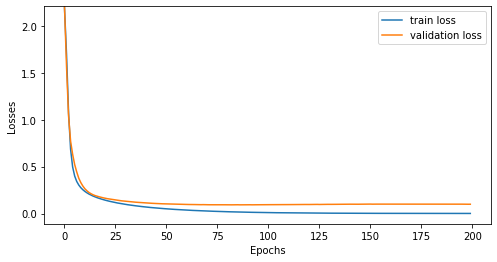

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.ylim(top=np.max(train_losses+val_losses))

#### Some additional tricks - Add learning rate scheduler 

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

In [ ]:
learning_rate = 1e-4
lambda_l2 = 1e-4

# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(H,C),
)

model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
scheduler = StepLR(optimizer, step_size=200, gamma=0.5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Training
best_val = 0.0
train_losses = []
val_losses = []
train_accuracies = []


# Training
for t in tqdm(range(300)):
    epoch_t_acc = 0.0 
    epoch_t_loss = 0.0
    
    for i, samples in enumerate(train_loader):
        model.train()
        # Feed forward to get the logits
        y_pred_train = model(samples['x'])

        # Compute the loss and accuracy
        loss = criterion(y_pred_train, samples['y'])
        score, predicted = torch.max(y_pred_train, 1)
        train_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()
        
        epoch_t_acc += train_acc
        epoch_t_loss += loss.item()
    
    train_accuracies.append(epoch_t_acc/len(train_loader))
    train_losses.append(epoch_t_loss/len(train_loader))
    
    model.eval()
    
    v_acc = 0.0
    v_loss = 0.0
    
    with torch.no_grad():
        for i, samples in enumerate(val_loader):
            y_pred_val = model(samples['x'])
            score, predicted = torch.max(y_pred_val, 1)
            val_loss = criterion(y_pred_val, samples['y'])
            val_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])
            
            v_acc += val_acc
            v_loss += val_loss.item()
            
    val_accuracies.append(v_acc/len(val_loader))
    val_losses.append(v_loss/len(val_loader))
    
    scheduler.step()
    # scheduler.step(v_loss/len(val_loader))


    if t%50 == 0:
        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))
        


[EPOCH]: 0, [TRAIN LOSS]: 2.197778, [TRAIN ACCURACY]: 0.282
[EPOCH]: 0, [VAL LOSS]: 2.405327, [VAL ACCURACY]: 0.580 

[EPOCH]: 50, [TRAIN LOSS]: 0.051772, [TRAIN ACCURACY]: 0.986
[EPOCH]: 50, [VAL LOSS]: 0.102530, [VAL ACCURACY]: 0.969 

[EPOCH]: 100, [TRAIN LOSS]: 0.011036, [TRAIN ACCURACY]: 0.999
[EPOCH]: 100, [VAL LOSS]: 0.095970, [VAL ACCURACY]: 0.974 

[EPOCH]: 150, [TRAIN LOSS]: 0.002865, [TRAIN ACCURACY]: 1.000
[EPOCH]: 150, [VAL LOSS]: 0.103637, [VAL ACCURACY]: 0.975 

[EPOCH]: 200, [TRAIN LOSS]: 0.001442, [TRAIN ACCURACY]: 1.000
[EPOCH]: 200, [VAL LOSS]: 0.102102, [VAL ACCURACY]: 0.974 

[EPOCH]: 250, [TRAIN LOSS]: 0.001281, [TRAIN ACCURACY]: 1.000
[EPOCH]: 250, [VAL LOSS]: 0.098349, [VAL ACCURACY]: 0.975 




In [ ]:
print(model)
print(f"Training accuracy of final model : {train_accuracies[-1]}")
print(f"Validation accuracy of final model: {val_accuracies[-1]}")
print(f"Training loss of final model : {train_losses[-1]}")
print(f"Validation loss of final model: {val_losses[-1]}")

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=128, out_features=10, bias=True)
)
Training accuracy of final model : 1.0
Validation accuracy of final model: 0.9749581217765808
Training loss of final model : 0.001173259628632543
Validation loss of final model: 0.09571973346173764


(-0.11903469481014846, 2.4053273677825926)

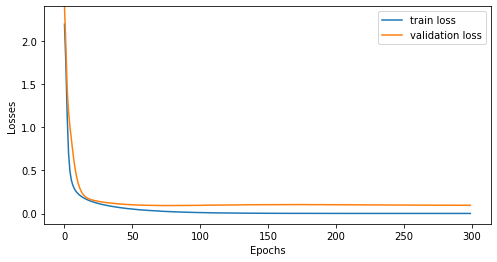

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.ylim(top=np.max(train_losses+val_losses))

#### Check what the last value of the lr was 

In [ ]:
scheduler.get_last_lr()

[5e-05]

#### Early stopping after exceeding max_patience number of epochs without improvement. 

#### Also an example of best practices to save current model

In [ ]:
learning_rate = 1e-4
lambda_l2 = 1e-4

# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(H,C),
)

model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
best_val = 0.0
train_losses = []
val_losses = []
train_accuracies = []
max_patience = 30
patience_counter = 0

# Training
for t in tqdm(range(200)):
    epoch_t_acc = 0.0 
    epoch_t_loss = 0.0
    
    for i, samples in enumerate(train_loader):
        model.train()
        # Feed forward to get the logits
        y_pred_train = model(samples['x'])

        # Compute the loss and accuracy
        loss = criterion(y_pred_train, samples['y'])
        score, predicted = torch.max(y_pred_train, 1)
        train_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()
        
        epoch_t_acc += train_acc
        epoch_t_loss += loss.item()
    
    train_accuracies.append(epoch_t_acc/len(train_loader))
    train_losses.append(epoch_t_loss/len(train_loader))
    
    model.eval()
    
    v_acc = 0.0
    v_loss = 0.0
    
    with torch.no_grad():
        for i, samples in enumerate(val_loader):
            y_pred_val = model(samples['x'])
            score, predicted = torch.max(y_pred_val, 1)
            val_loss = criterion(y_pred_val, samples['y'])
            val_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])
            
            v_acc += val_acc
            v_loss += val_loss.item()

    val_accuracies.append(v_acc/len(val_loader))
    val_losses.append(v_loss/len(val_loader))

    if val_accuracies[-1] > best_val:
      best_val = val_accuracies[-1]
      patience_counter = 0
      torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': t,
                }, '/content/drive/My Drive/Colab Notebooks/checkpoint.pth')
    else:
      patience_counter += 1    
      if patience_counter > max_patience:
        break


    if t%50 == 0:
        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))
        


[EPOCH]: 0, [TRAIN LOSS]: 2.130384, [TRAIN ACCURACY]: 0.461
[EPOCH]: 0, [VAL LOSS]: 2.110391, [VAL ACCURACY]: 0.696 

[EPOCH]: 50, [TRAIN LOSS]: 0.049483, [TRAIN ACCURACY]: 0.987
[EPOCH]: 50, [VAL LOSS]: 0.102307, [VAL ACCURACY]: 0.969 

[EPOCH]: 100, [TRAIN LOSS]: 0.010181, [TRAIN ACCURACY]: 0.999
[EPOCH]: 100, [VAL LOSS]: 0.098155, [VAL ACCURACY]: 0.971 

[EPOCH]: 150, [TRAIN LOSS]: 0.002689, [TRAIN ACCURACY]: 1.000
[EPOCH]: 150, [VAL LOSS]: 0.105512, [VAL ACCURACY]: 0.972 




In [ ]:
print(model)
print(f"Training accuracy of final model : {train_accuracies[-1]}")
print(f"Validation accuracy of final model: {val_accuracies[-1]}")
print(f"Training loss of final model : {train_losses[-1]}")
print(f"Validation loss of final model: {val_losses[-1]}")
print(f"Best Validation accuracy: {best_val}")

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=10, bias=True)
)
Training accuracy of final model : 1.0
Validation accuracy of final model: 0.972359299659729
Training loss of final model : 0.0014321747739628262
Validation loss of final model: 0.10496664121747017
Best Validation accuracy: 0.9730728268623352


(-0.10501540991767519, 2.130383868606723)

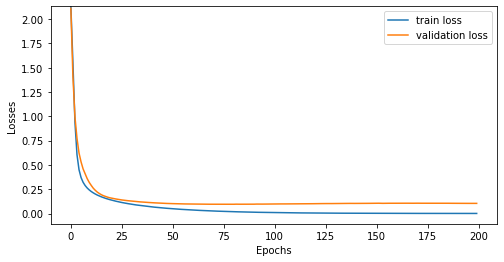

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.ylim(top=np.max(train_losses+val_losses))

#### Reduce the dimensionality of the data

In [ ]:
cov = np.dot(X_train.T, X_train) / X_train.shape[0] # get the data covariance matrix

In [ ]:
U,S,V = np.linalg.svd(cov)

In [ ]:
X_train_red = np.dot(X_train, U[:,:50])
X_val_red = np.dot(X_val, U[:,:50])
X_test_red = np.dot(X_val, U[:,:50])

In [ ]:
train_dataset = MNISTDataset(X_train_red, y_train)
print(f"Lenth of train dataset {len(train_dataset)}")
val_dataset = MNISTDataset(X_val_red, y_val)
print(f"Lenth of val dataset {len(val_dataset)}")
test_dataset = MNISTDataset(X_test_red, y_test)
print(f"Lenth of test dataset {len(test_dataset)}")

Lenth of train dataset 50000
Lenth of val dataset 10000
Lenth of test dataset 10000


#### Define the sampler 

In [ ]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
val_sampler = torch.utils.data.SequentialSampler(val_dataset)
test_sampler = torch.utils.data.SequentialSampler(test_dataset)

#### Define the data loader 

In [ ]:
bs = 1024 # Define the batch size

train_loader = DataLoader(train_dataset, batch_size=bs, sampler=train_sampler, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=bs, sampler=val_sampler, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=bs, sampler=test_sampler, drop_last=False)

In [ ]:
learning_rate = 1e-4
lambda_l2 = 1e-4

# Only 50 dimensions
D = 50
# Half the number of neurons
H = 64

# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(H,C),
)

model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
best_val = 0.0
train_losses = []
val_losses = []
train_accuracies = []
max_patience = 30
patience_counter = 0

# Training
for t in tqdm(range(400)):
    epoch_t_acc = 0.0 
    epoch_t_loss = 0.0
    
    for i, samples in enumerate(train_loader):
        model.train()
        
        # Feed forward to get the logits
        y_pred_train = model(samples['x'])

        # Compute the loss and accuracy
        loss = criterion(y_pred_train, samples['y'])
        score, predicted = torch.max(y_pred_train, 1)
        train_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()
        
        epoch_t_acc += train_acc
        epoch_t_loss += loss.item()
    
    train_accuracies.append(epoch_t_acc/len(train_loader))
    train_losses.append(epoch_t_loss/len(train_loader))
    
    model.eval()
    
    v_acc = 0.0
    v_loss = 0.0
    
    with torch.no_grad():
        for i, samples in enumerate(val_loader):
            y_pred_val = model(samples['x'])
            score, predicted = torch.max(y_pred_val, 1)
            val_loss = criterion(y_pred_val, samples['y'])
            val_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])
            
            v_acc += val_acc
            v_loss += val_loss.item()

    val_accuracies.append(v_acc/len(val_loader))
    val_losses.append(v_loss/len(val_loader))

    if val_accuracies[-1] > best_val:
      best_val = val_accuracies[-1]
      patience_counter = 0
    else:
      patience_counter += 1    
      if patience_counter > max_patience:
        break


    if t%50 == 0:
        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))
        


[EPOCH]: 0, [TRAIN LOSS]: 2.416270, [TRAIN ACCURACY]: 0.109
[EPOCH]: 0, [VAL LOSS]: 2.264662, [VAL ACCURACY]: 0.180 

[EPOCH]: 50, [TRAIN LOSS]: 0.189484, [TRAIN ACCURACY]: 0.943
[EPOCH]: 50, [VAL LOSS]: 0.191549, [VAL ACCURACY]: 0.941 

[EPOCH]: 100, [TRAIN LOSS]: 0.114711, [TRAIN ACCURACY]: 0.965
[EPOCH]: 100, [VAL LOSS]: 0.133848, [VAL ACCURACY]: 0.960 

[EPOCH]: 150, [TRAIN LOSS]: 0.084594, [TRAIN ACCURACY]: 0.974
[EPOCH]: 150, [VAL LOSS]: 0.114353, [VAL ACCURACY]: 0.965 

[EPOCH]: 200, [TRAIN LOSS]: 0.067504, [TRAIN ACCURACY]: 0.980
[EPOCH]: 200, [VAL LOSS]: 0.104411, [VAL ACCURACY]: 0.968 

[EPOCH]: 250, [TRAIN LOSS]: 0.056119, [TRAIN ACCURACY]: 0.983
[EPOCH]: 250, [VAL LOSS]: 0.101006, [VAL ACCURACY]: 0.969 



In [ ]:
print(model)
print(f"Training accuracy of final model : {train_accuracies[-1]}")
print(f"Validation accuracy of final model: {val_accuracies[-1]}")
print(f"Training loss of final model : {train_losses[-1]}")
print(f"Validation loss of final model: {val_losses[-1]}")
print(f"Best Validation accuracy: {best_val}")

Sequential(
  (0): Linear(in_features=50, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=64, out_features=10, bias=True)
)
Training accuracy of final model : 0.9845960736274719
Validation accuracy of final model: 0.9689652323722839
Training loss of final model : 0.05221077769386525
Validation loss of final model: 0.10010193139314652
Best Validation accuracy: 0.969640851020813


(-0.06599218819518479, 2.416270095474866)

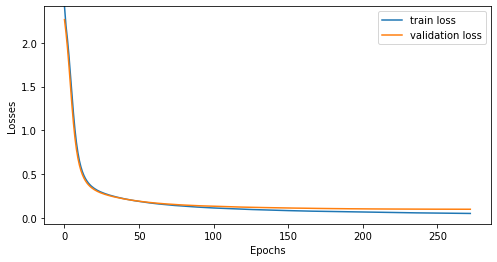

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.ylim(top=np.max(train_losses+val_losses))

#### Get results on test set in the very end

In [ ]:
model.eval()
with torch.no_grad():
  t_acc = 0
  t_loss = 0
  for i, samples in enumerate(test_loader):
            y_pred_test = model(samples['x'])
            score, predicted = torch.max(y_pred_test, 1)
            test_loss = criterion(y_pred_test, samples['y'])
            test_acc = (samples['y'] == predicted).sum().float() / len(samples['y'])
            
            t_acc += test_acc
            t_loss += test_loss.item()

    val_accuracies.append(t_acc/len(test_loader))
    val_losses.append(t_loss/len(test_loader))